In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
image_path = download_data(
    source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
    destination="pizza_steak_sushi",
)
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [4]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

In [5]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
    ]
)
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [6]:
# Set the batch size
BATCH_SIZE = (
    32  # this is lower than the ViT paper but it's because we're starting small
)

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,  # use manually created transforms
    batch_size=BATCH_SIZE,
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7c9cc3538560>,
 ['pizza', 'steak', 'sushi'])

In [7]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

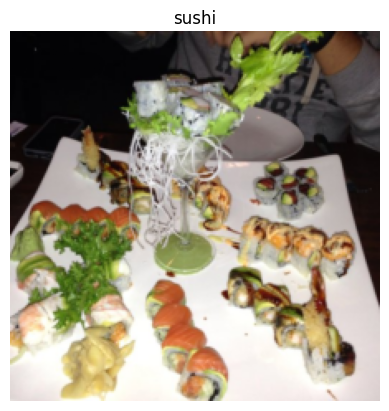

In [8]:
plt.imshow(
    image.permute(1, 2, 0)
)  # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False)

In [9]:
height = 224
width = 224
color_channels = 3
patch_size = 16

number_of_patches = int((height * width) / patch_size**2)

In [10]:
embedding_layer_input_shape = (height, width, color_channels)
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(embedding_layer_input_shape)
print(embedding_layer_output_shape)

(224, 224, 3)
(196, 768)


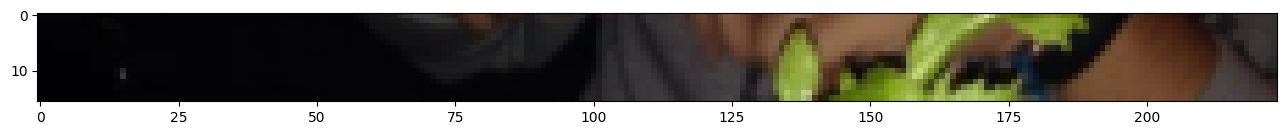

In [11]:
image_permuted = image.permute(1, 2, 0)
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:16, :, :])

In [12]:
def patchifying(img):
    img_size = 224
    patch_size = 16
    image_permuted = img.permute(1, 2, 0)

    fig, axs = plt.subplots(
        nrows=img_size // patch_size,
        ncols=img_size // patch_size,
        sharex=True,
        sharey=True,
    )

    counter = 0
    next_patch_size_length = patch_size
    while next_patch_size_length <= image_permuted.shape[0]:
        next_patch_size_width = patch_size
        while next_patch_size_width <= image_permuted.shape[1]:
            ax = axs.flat[counter]
            ax.imshow(
                image_permuted[
                    next_patch_size_length - patch_size:next_patch_size_length,
                    next_patch_size_width - patch_size:next_patch_size_width,
                    :,
                ]
            )
            ax.set_xlabel(counter + 1)
            ax.set_xticks([])
            ax.set_yticks([])
            next_patch_size_width += patch_size
            counter += 1
        next_patch_size_length += patch_size


In [13]:
# patchifying(image)

In [14]:
class PatchEmbedding(nn.Module):
    def __init__(self, channel_size=3, patch_size=16, embed_dim=768) -> None:
        super().__init__()

        self.patch_size = patch_size
        self.channel_size = channel_size
        self.embed_dim = embed_dim

        self.conv = nn.Conv2d(
            in_channels=channel_size,
            out_channels=embed_dim,
            kernel_size=patch_size,
            stride=patch_size,
            padding=0
        )
        self.flattening = nn.Flatten(start_dim=2, end_dim=3)

    def forward(self, x):
        b, c, h, w = x.shape
        assert c == self.channel_size, f"Expected {self.channel_size} channels, got {c}"
        assert h % self.patch_size == 0 and w % self.patch_size == 0, "Image size not divisible by patch size"

        patches = self.conv(x)  # [B, embed_dim, H/patch, W/patch]
        patches = self.flattening(patches).transpose(1, 2)  # [B, num_patches, embed_dim]
        return patches

In [15]:
model = PatchEmbedding()
patch_embedded_image = model(image.unsqueeze(0))

In [16]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [17]:
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
batch_size, embedding_dimension

(1, 768)

In [18]:
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), requires_grad=True)

In [19]:
class_token.shape

torch.Size([1, 1, 768])

In [20]:
patch_embedded_image_with_class_embedding = torch.cat(
    (class_token, patch_embedded_image), dim=1
)

In [21]:
patch_embedded_image_with_class_embedding.shape

torch.Size([1, 197, 768])

In [22]:
patch_embedded_image_with_class_embedding

tensor([[[ 1.0000e+00,  1.0000e+00,  1.0000e+00,  ...,  1.0000e+00,
           1.0000e+00,  1.0000e+00],
         [-1.1456e-02, -2.8138e-02,  9.6002e-03,  ...,  5.9345e-03,
          -2.1597e-02,  1.5634e-03],
         [-6.0989e-03, -1.5431e-02,  3.6360e-03,  ..., -7.9393e-04,
          -3.2959e-02,  1.2954e-02],
         ...,
         [ 5.1511e-01,  9.0867e-01, -9.4504e-02,  ..., -6.6522e-01,
          -2.7216e-01,  3.4278e-02],
         [ 4.9804e-01,  8.4020e-01, -1.1883e-01,  ..., -6.7029e-01,
          -4.1550e-01, -5.7403e-03],
         [ 4.5135e-01,  8.0538e-01, -8.6813e-02,  ..., -5.8000e-01,
          -2.7024e-01,  5.8825e-02]]], grad_fn=<CatBackward0>)

In [23]:
number_of_patches = int((height * width) / patch_size**2)

embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]

position_embedding = nn.Parameter(
    torch.ones(1, number_of_patches + 1, embedding_dimension), requires_grad=True
)  

In [24]:
set_seeds()
patch_size = 16
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

patch_embedding_layer = PatchEmbedding(
    channel_size=3, patch_size=patch_size, embed_dim=768
)
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(
    torch.ones(batch_size, 1, embedding_dimension), requires_grad=True
) 
print(f"Class token embedding shape: {class_token.shape}")

patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(
    torch.ones(1, number_of_patches + 1, embedding_dimension), requires_grad=True
) 

patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


In [25]:
# patch_and_position_embedding_normalized = nn.LayerNorm(patch_and_position_embedding)

class MutliSelfAttentionBlock(nn.Module):

    def __init__(self, embedding_dim=768, nhead=3, dropout=0.0):
        super().__init__()
        self.layer_norm = nn.LayerNorm(
            normalized_shape=embedding_dim, eps=1e-5, elementwise_affine=True
        )
        self.attn = nn.MultiheadAttention(
            embedding_dim, nhead, dropout=dropout, batch_first=True
        )

    def forward(self, x):
        attn_output, _ = self.attn(self.layer_norm(x), self.layer_norm(x), self.layer_norm(x), need_weights=False)
        return attn_output

mutli_head = MutliSelfAttentionBlock()

In [26]:
patch_and_position_embedding.shape, mutli_head(patch_and_position_embedding).shape

(torch.Size([1, 197, 768]), torch.Size([1, 197, 768]))

In [27]:
class MLPBlock(nn.Module):

    def __init__(self,
                 embedding_dim:int=768, 
                 mlp_size:int=3072,
                 dropout:float=0.1):
        super().__init__()
        self.layer_norm = nn.LayerNorm(
            normalized_shape=embedding_dim, eps=1e-5, elementwise_affine=True
        )
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim, out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(in_features=mlp_size, out_features=embedding_dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.mlp(self.layer_norm(x))

In [28]:
mlp_model = MLPBlock()
mlp_model(mutli_head(patch_and_position_embedding))

tensor([[[-0.0644,  0.0072,  0.2318,  ..., -0.0206, -0.0831,  0.3167],
         [-0.0345,  0.0315,  0.2019,  ..., -0.0000, -0.1383,  0.2798],
         [-0.0647, -0.0607,  0.1485,  ..., -0.0281, -0.1855,  0.3466],
         ...,
         [-0.0434, -0.0726,  0.1619,  ...,  0.0850, -0.1512,  0.1561],
         [-0.0819, -0.0000,  0.1310,  ...,  0.1653, -0.1656,  0.2443],
         [-0.1009,  0.0137,  0.0802,  ...,  0.1275, -0.0269,  0.2829]]],
       grad_fn=<MulBackward0>)

In [29]:
class TransformerEncoderBlock(nn.Module):
    def __init__(
        self,
        embedding_dim: int = 768,
        num_heads: int = 12, 
        mlp_size: int = 3072,  
        mlp_dropout: float = 0.1, 
        attn_dropout: float = 0,
    ): 
        super().__init__()
        self.msa_block = MutliSelfAttentionBlock(
            embedding_dim=embedding_dim, nhead=num_heads, dropout=attn_dropout
        )

        self.mlp_block = MLPBlock(
            embedding_dim=embedding_dim, mlp_size=mlp_size, dropout=mlp_dropout
        )

    def forward(self, x):
        x = self.msa_block(x) + x
        x = self.mlp_block(x) + x

        return x

In [30]:
transformer = TransformerEncoderBlock()
transformer(patch_and_position_embedding)

tensor([[[ 1.7132,  2.2044,  1.1773,  ...,  2.4901,  1.6439,  2.8358],
         [ 0.7599,  1.2268,  0.1019,  ...,  1.3482,  0.7071,  1.9311],
         [ 0.6505,  1.2387,  0.0384,  ...,  1.6087,  0.8019,  1.9541],
         ...,
         [-0.2470,  0.9696, -0.3892,  ...,  1.9175,  0.1820,  1.9109],
         [-0.2331,  1.1663, -0.3036,  ...,  1.7815,  0.2545,  1.9652],
         [ 0.0386,  1.1160, -0.4948,  ...,  1.8266,  0.2900,  1.8992]]],
       grad_fn=<AddBackward0>)

In [31]:
from torchinfo import summary

summary(model=transformer,
        input_size=(1, 197, 768),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MutliSelfAttentionBlock (msa_block)              [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        (recursive)          True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        (recursive)          True
│    └─MultiheadAttention (attn)                   [1, 197, 768]        [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)              

In [32]:
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768,
                                                             nhead=12,
                                                             dim_feedforward=3072,
                                                             activation="gelu",
                                                             batch_first=True,
                                                             norm_first=True)

In [33]:
summary(
    model=torch_transformer_encoder_layer,
    input_size=(1, 197, 768),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"],
)

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        --                   True
├─LayerNorm (norm1)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─MultiheadAttention (self_attn)                   [1, 197, 768]        [1, 197, 768]        2,362,368            True
├─Dropout (dropout1)                               [1, 197, 768]        [1, 197, 768]        --                   --
├─LayerNorm (norm2)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─Linear (linear1)                                 [1, 197, 768]        [1, 197, 3072]       2,362,368            True
├─Dropout (dropout)                                [1, 197, 3072]       [1, 197, 3072]       --                   --
├─Linear (linear2)                             

In [35]:
class ViT(nn.Module):
    def __init__(
        self,
        img_size: int = 224, 
        in_channels: int = 3,
        patch_size: int = 16,  
        num_transformer_layers: int = 12,  
        embedding_dim: int = 768,  
        mlp_size: int = 3072, 
        num_heads: int = 12,  
        attn_dropout: float = 0,  
        mlp_dropout: float = 0.1,  
        embedding_dropout: float = 0.1,  
        num_classes: int = 1000,
    ):  
        super().__init__()

        assert img_size % patch_size == 0, f"Image size must be divisible by patch size"
        self.num_patches = (img_size * img_size) // patch_size ** 2

        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim), requires_grad=True)

        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim))

        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        self.patch_embedding = PatchEmbedding(channel_size=in_channels, patch_size=patch_size,
                                              embed_dim=embedding_dim)

        self.transformer_encoder = nn.Sequential(
            *[
                TransformerEncoderBlock(
                    embedding_dim=embedding_dim,
                    num_heads=num_heads,
                    mlp_size=mlp_size,
                    mlp_dropout=mlp_dropout,
                )
                for _ in range(num_transformer_layers)
            ]
        )
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, out_features=num_classes),
        )

    def forward(self, x):

        batch_size = x.shape[0]

        class_token = self.class_embedding.expand(
            batch_size, -1, -1
        ) 

        x = self.patch_embedding(x)

        x = torch.cat((class_token, x), dim=1)

        x = self.position_embedding + x

        x = self.embedding_dropout(x)

        x = self.transformer_encoder(x)

        x = self.classifier(x[:, 0]) 

        return x

In [36]:
vit = ViT()
vit

ViT(
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (patch_embedding): PatchEmbedding(
    (conv): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (flattening): Flatten(start_dim=2, end_dim=3)
  )
  (transformer_encoder): Sequential(
    (0): TransformerEncoderBlock(
      (msa_block): MutliSelfAttentionBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
      )
      (mlp_block): MLPBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (1): Transfo

In [37]:
summary(
    model=vit,
    input_size=(1, 3, 224, 224),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"],
)

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                               [1, 3, 224, 224]     [1, 1000]            152,064              True
├─PatchEmbedding (patch_embedding)                      [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (conv)                                    [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flattening)                             [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                           [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder)                      [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncoderBlock (0)                      [1, 197, 768]        [1, 197, 768]        --                   True
│    │ 

In [38]:
from going_modular.going_modular import engine

optimizer = torch.optim.Adam(
    params=vit.parameters(),
    lr=3e-3, 
    betas=(
        0.9,
        0.999,
    ),  
    weight_decay=0.3,
) 

loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()

results = engine.train(
    model=vit,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=10,
    device=device,
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.2313 | train_acc: 0.2305 | test_loss: 2.5121 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.9579 | train_acc: 0.2773 | test_loss: 2.9822 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.5328 | train_acc: 0.4844 | test_loss: 2.2434 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.4525 | train_acc: 0.3008 | test_loss: 1.5492 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.2790 | train_acc: 0.2578 | test_loss: 1.2897 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.2274 | train_acc: 0.3125 | test_loss: 1.3544 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.3226 | train_acc: 0.2812 | test_loss: 1.2590 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.1641 | train_acc: 0.3906 | test_loss: 1.2261 | test_acc: 0.2604
Epoch: 9 | train_loss: 1.2218 | train_acc: 0.3047 | test_loss: 1.0484 | test_acc: 0.5417
Epoch: 10 | train_loss: 1.3278 | train_acc: 0.2617 | test_loss: 1.4667 | test_acc: 0.2604


In [46]:
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights)
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
    
pretrained_vit.heads = nn.Linear(in_features=768, out_features=3).to(device)

In [47]:
summary(
    model=pretrained_vit,
    input_size=(1, 3, 224, 224),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"],
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [ ]:
pretrained_vit

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [49]:
from going_modular.going_modular import engine

optimizer = torch.optim.Adam(
    params=pretrained_vit.parameters(),
    lr=3e-3,
    betas=(
        0.9,
        0.999,
    ),
    weight_decay=0.3,
)

loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()

results = engine.train(
    model=pretrained_vit,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=10,
    device=device,
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6629 | train_acc: 0.6602 | test_loss: 0.3413 | test_acc: 0.8977
Epoch: 2 | train_loss: 0.2193 | train_acc: 0.9492 | test_loss: 0.2248 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.1440 | train_acc: 0.9609 | test_loss: 0.2481 | test_acc: 0.8977
Epoch: 4 | train_loss: 0.1266 | train_acc: 0.9727 | test_loss: 0.2088 | test_acc: 0.9280
Epoch: 5 | train_loss: 0.1143 | train_acc: 0.9844 | test_loss: 0.2308 | test_acc: 0.9280
Epoch: 6 | train_loss: 0.1286 | train_acc: 0.9883 | test_loss: 0.2378 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.1383 | train_acc: 0.9922 | test_loss: 0.2493 | test_acc: 0.9280
Epoch: 8 | train_loss: 0.1358 | train_acc: 0.9844 | test_loss: 0.2296 | test_acc: 0.9280
Epoch: 9 | train_loss: 0.1704 | train_acc: 0.9961 | test_loss: 0.2169 | test_acc: 0.9176
Epoch: 10 | train_loss: 0.1722 | train_acc: 0.9414 | test_loss: 0.2483 | test_acc: 0.9280


In [52]:
from pathlib import Path

save_path = Path("Vit_mini_food.pth")  
torch.save(pretrained_vit.state_dict(), save_path)

In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torchvision.models.vit_b_16(weights=None)  # same backbone
model.heads = nn.Linear(768, 3)
state = torch.load("Vit_mini_food.pth", map_location=device)
model.load_state_dict(state)
model.to(device).eval()

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a